Group 9 Problem Statement:
Dataset : horses_or_humans - A large set of images of horses and humans

Import required libraries

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from google.colab import files
from keras.preprocessing import image

from keras.applications import vgg16
from keras.models import Model
from glob import glob
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.applications.resnet50 import preprocess_input
import cv2
import fnmatch
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import SGD
from keras.optimizers import Adam 
from tensorflow import keras


In [50]:
input_shape = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output

vgg_model = Model(vgg.input, output)
vgg_model.output

<tf.Tensor 'block5_pool_1/MaxPool:0' shape=(?, 4, 4, 512) dtype=float32>

Load data                                             
After extracting its contents, assign variables with the proper file path for the training and validation set.

In [0]:
# Directory with our training horse pictures
train_horse_dir = os.path.join('/content/drive/My Drive/Colab Notebooks/horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('/content/drive/My Drive/Colab Notebooks/horse-or-human/humans')

# Directory with our training horse pictures
validation_horse_dir = os.path.join('/content/drive/My Drive/Colab Notebooks/validation-horse-or-human/horses')

# Directory with our Validation human pictures
validation_human_dir = os.path.join('/content/drive/My Drive/Colab Notebooks/validation-horse-or-human/humans')

train_dir = os.path.join('/content/drive/My Drive/Colab Notebooks/horse-or-human')
validation_dir = os.path.join('/content/drive/My Drive/Colab Notebooks/validation-horse-or-human')


Understand the data

In [0]:

train_horse_names = os.listdir(train_horse_dir)
#print(train_horse_names[:10])
train_human_names = os.listdir(train_human_dir)
#print(train_human_names[:10])
validation_horse_names = os.listdir(validation_horse_dir)
#print(validation_horse_names[:10])
validation_human_names = os.listdir(validation_human_dir)
#print(validation_human_names[:10])



Train Dataset                   
Reading the images and merging them in one list

In [0]:
IMG_DIM = (150, 150)

train_horse_files = glob('/content/drive/My Drive/Colab Notebooks/horse-or-human/horses/*.png', recursive=True)
#train_files = data_dir+'train/'

train_horse_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_horse_files]
train_horse_imgs = np.array(train_horse_imgs)

train_human_files = glob('/content/drive/My Drive/Colab Notebooks/horse-or-human/humans/*.png', recursive=True)
#train_files = data_dir+'train/'
#train_files = train_files + train_human_files
train_human_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_human_files]
train_human_imgs = np.array(train_human_imgs)

In [0]:
train_data = np.append(train_horse_imgs,train_human_imgs,axis=0)


In [0]:
train_labels = []
for img in train_horse_files:
    full_size_image = cv2.imread(img)
    im = cv2.resize(full_size_image, (224, 224), interpolation=cv2.INTER_CUBIC)
    train_labels.append(0)

for img in train_human_files:
    full_size_image = cv2.imread(img)
    im = cv2.resize(full_size_image, (224, 224), interpolation=cv2.INTER_CUBIC)
    train_labels.append(1)


Validation Data

In [0]:
validation_horse_files = glob('/content/drive/My Drive/Colab Notebooks/validation-horse-or-human/horses/*.png', recursive=True)
validation_horse_imgs  = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_horse_files]
validation_horse_imgs  = np.array(validation_horse_imgs)

validation_human_files = glob('/content/drive/My Drive/Colab Notebooks/validation-horse-or-human/humans/*.png', recursive=True)
validation_human_imgs  = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_human_files]
validation_human_imgs  = np.array(validation_human_imgs)


In [0]:
validation_data = np.append(validation_horse_imgs,validation_human_imgs,axis=0)


In [0]:
validation_labels = []
for img in validation_horse_files:
    full_size_image = cv2.imread(img)
    im = cv2.resize(full_size_image, (224, 224), interpolation=cv2.INTER_CUBIC)
    validation_labels.append(0)

for img in validation_human_files:
    full_size_image = cv2.imread(img)
    im = cv2.resize(full_size_image, (224, 224), interpolation=cv2.INTER_CUBIC)
    validation_labels.append(1)


Visualize the data

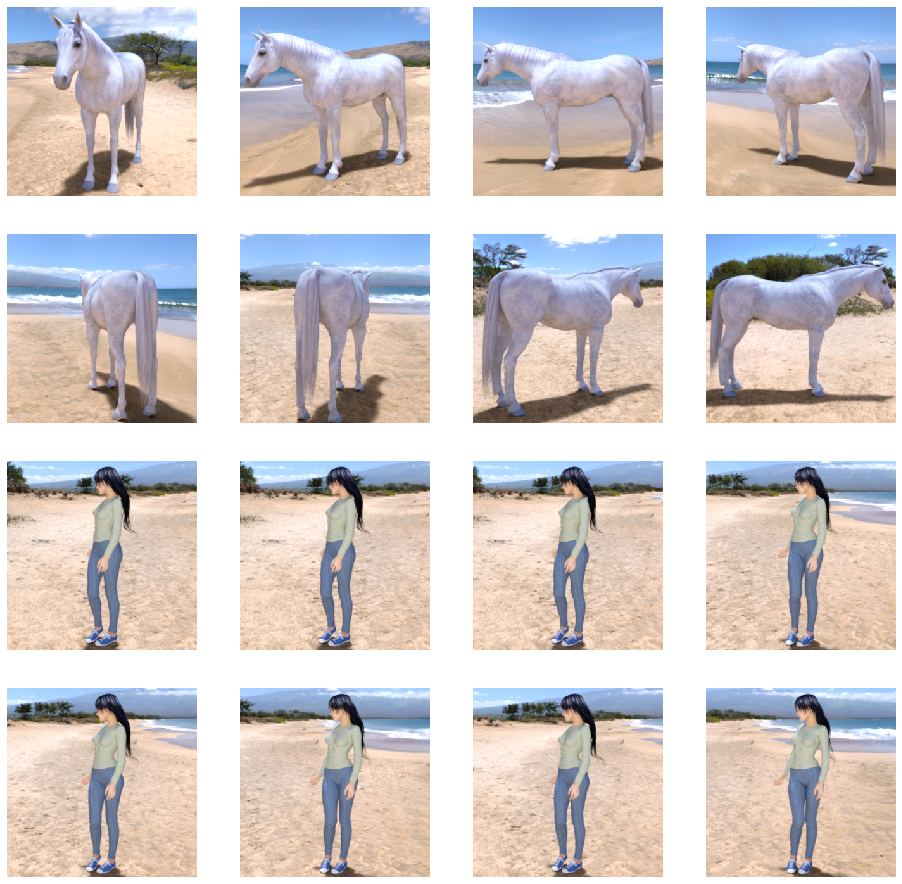

In [59]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4
# Index for iterating over images
pic_index = 0
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname) 
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname) 
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

Data preprocessing

In [0]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

(150, 150, 3)


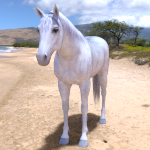

In [61]:
train_imgs_scaled = train_data.astype('float32')
validation_imgs_scaled  = validation_data.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

print(train_data[0].shape)
array_to_img(train_data[0])

(1, 4, 4, 512)


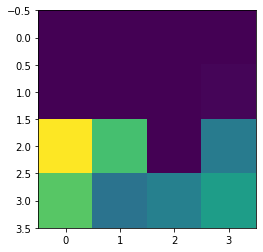

In [62]:
bottleneck_feature_example = vgg.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:,:,0])

Train the model

In [63]:
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features
    
train_features_vgg = get_bottleneck_features(vgg_model, train_imgs_scaled)
validation_features_vgg = get_bottleneck_features(vgg_model, validation_imgs_scaled)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape)

Train Bottleneck Features: (528, 4, 4, 512) 	Validation Bottleneck Features: (256, 4, 4, 512)


1. 
1 Hidden Layer of 32 units, dropout ratio 0.25, relu for the hidden layer and sigmoid for output layer batch size 64, optimiser adam with lr 1e-03

In [64]:
# Create the model for Relu as hidden layer
model1 = Sequential()

# Specify the input size for first layer
model1.add(Flatten())
model1.add(layers.Dense(32, activation='relu', input_shape= ( 32*32,)))
model1.add(layers.Dropout(0.25))

# output layer
model1.add(layers.Dense(10, activation='sigmoid'))
# Compile model
opt1= keras.optimizers.Adam(lr=1e-03)
model1.compile(loss='binary_crossentropy', optimizer=opt1, metrics=['accuracy'])
# Train the model
history1 = model1.fit(x=train_features_vgg, y=train_labels_enc,
                    validation_data=(validation_features_vgg, validation_labels_enc),
                    batch_size=64,
                    epochs=20,             
                    verbose=2)
print("==========================Model Evalutation=========================")
testLoss, testAccuracy = model1.evaluate( validation_features_vgg, validation_labels_enc)
print('Loss \t', testLoss)
print('Accuracy ', testAccuracy * 100, '%')

predictions1 = model1.predict(validation_features_vgg)
y_pred = (predictions1 > 0.5)
y_pred = np.argmax(predictions1, axis=1)
print('Confusion Matrix')
confusion_matrix(validation_labels_enc, y_pred)



Train on 528 samples, validate on 256 samples
Epoch 1/20
528/528 - 1s - loss: 0.5643 - acc: 0.7076 - val_loss: 0.4175 - val_acc: 0.8496
Epoch 2/20
528/528 - 0s - loss: 0.3798 - acc: 0.8462 - val_loss: 0.3132 - val_acc: 0.9098
Epoch 3/20
528/528 - 0s - loss: 0.3150 - acc: 0.8655 - val_loss: 0.2560 - val_acc: 0.9191
Epoch 4/20
528/528 - 0s - loss: 0.2717 - acc: 0.8769 - val_loss: 0.2293 - val_acc: 0.9168
Epoch 5/20
528/528 - 0s - loss: 0.2342 - acc: 0.8955 - val_loss: 0.1970 - val_acc: 0.9270
Epoch 6/20
528/528 - 0s - loss: 0.2092 - acc: 0.8998 - val_loss: 0.1793 - val_acc: 0.9277
Epoch 7/20
528/528 - 0s - loss: 0.1800 - acc: 0.9197 - val_loss: 0.1674 - val_acc: 0.9520
Epoch 8/20
528/528 - 0s - loss: 0.1518 - acc: 0.9375 - val_loss: 0.1536 - val_acc: 0.9609
Epoch 9/20
528/528 - 0s - loss: 0.1259 - acc: 0.9528 - val_loss: 0.1508 - val_acc: 0.9594
Epoch 10/20
528/528 - 0s - loss: 0.1068 - acc: 0.9604 - val_loss: 0.1494 - val_acc: 0.9559
Epoch 11/20
528/528 - 0s - loss: 0.1005 - acc: 0.9608

array([[  0,   0,  14,  12,  94,   8],
       [  0,   0, 128,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0]])

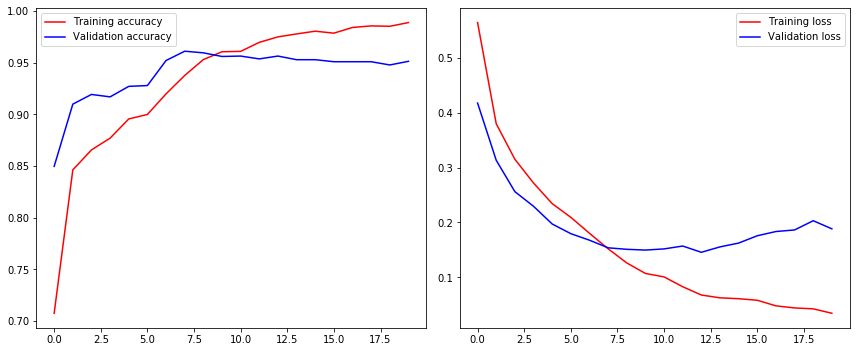

In [65]:
acc = history1.history['acc']
val_acc = history1.history['val_acc']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

fit, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.axes_style('whitegrid')
# plot acrruacy by epochs
sns.lineplot(x=epochs, y=acc, color='r', label='Training accuracy', ax=axes[0])
sns.lineplot(x=epochs, y=val_acc, color = 'b', label='Validation accuracy', ax=axes[0])
# plot loss by epochs
sns.lineplot(x=epochs, y=loss, color='r', label='Training loss', ax=axes[1])
sns.lineplot(x=epochs, y=val_loss, color = 'b', label='Validation loss', ax=axes[1])
plt.tight_layout()
plt.show();

2.
1 Hidden Layer of 32 units, dropout ratio 0.25, relu for the hidden layer and sigmoid for output layer batch size 256, optimiser adam with lr 1e-03

In [66]:
# Create the model for Relu as hidden layer
model2 = Sequential()

# Specify the input size for first layer
model2.add(Flatten())
model2.add(layers.Dense(32, activation='relu', input_shape= ( 32*32,)))
model2.add(layers.Dropout(0.25))

# output layer
model2.add(layers.Dense(10, activation='sigmoid'))
# Compile model
opt2= keras.optimizers.Adam(lr=1e-03)
model2.compile(loss='binary_crossentropy', optimizer=opt2, metrics=['accuracy'])
# Train the model
history2 = model2.fit(x=train_features_vgg, y=train_labels_enc,
                    validation_data=(validation_features_vgg, validation_labels_enc),
                    batch_size=256,
                    epochs=20,             
                    verbose=2)
print("==========================Model Evalutation=========================")
testLoss, testAccuracy = model1.evaluate( validation_features_vgg, validation_labels_enc)
print('Loss \t', testLoss)
print('Accuracy ', testAccuracy * 100, '%')

predictions2 = model2.predict(validation_features_vgg)
y_pred = (predictions2 > 0.5)
y_pred = np.argmax(predictions2, axis=1)
print('Confusion Matrix')
confusion_matrix(validation_labels_enc, y_pred)


Train on 528 samples, validate on 256 samples
Epoch 1/20
528/528 - 1s - loss: 0.7104 - acc: 0.5242 - val_loss: 0.6024 - val_acc: 0.7320
Epoch 2/20
528/528 - 0s - loss: 0.5962 - acc: 0.6860 - val_loss: 0.5176 - val_acc: 0.7738
Epoch 3/20
528/528 - 0s - loss: 0.5248 - acc: 0.7413 - val_loss: 0.4563 - val_acc: 0.7879
Epoch 4/20
528/528 - 0s - loss: 0.4996 - acc: 0.7559 - val_loss: 0.4353 - val_acc: 0.8285
Epoch 5/20
528/528 - 0s - loss: 0.4624 - acc: 0.7797 - val_loss: 0.4243 - val_acc: 0.7891
Epoch 6/20
528/528 - 0s - loss: 0.4397 - acc: 0.7833 - val_loss: 0.3940 - val_acc: 0.8332
Epoch 7/20
528/528 - 0s - loss: 0.4129 - acc: 0.8080 - val_loss: 0.3629 - val_acc: 0.8613
Epoch 8/20
528/528 - 0s - loss: 0.4161 - acc: 0.8036 - val_loss: 0.3467 - val_acc: 0.8496
Epoch 9/20
528/528 - 0s - loss: 0.4005 - acc: 0.8110 - val_loss: 0.3469 - val_acc: 0.8480
Epoch 10/20
528/528 - 0s - loss: 0.3812 - acc: 0.8206 - val_loss: 0.3470 - val_acc: 0.8590
Epoch 11/20
528/528 - 0s - loss: 0.3671 - acc: 0.8326

array([[  0,   0,  18,   1, 109],
       [  0,   0, 128,   0,   0],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0]])

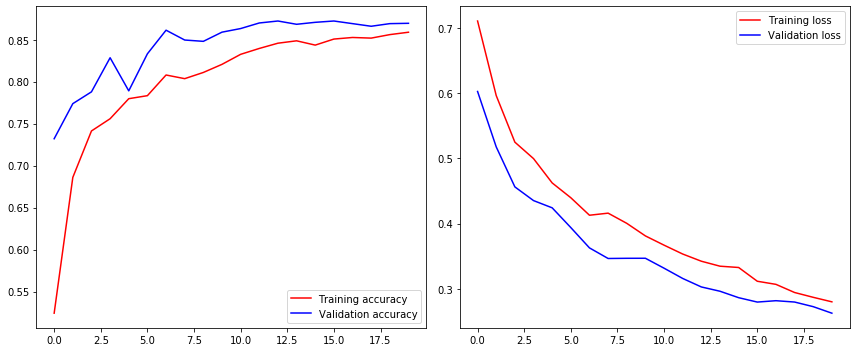

In [67]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

fit, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.axes_style('whitegrid')
# plot acrruacy by epochs
sns.lineplot(x=epochs, y=acc, color='r', label='Training accuracy', ax=axes[0])
sns.lineplot(x=epochs, y=val_acc, color = 'b', label='Validation accuracy', ax=axes[0])
# plot loss by epochs
sns.lineplot(x=epochs, y=loss, color='r', label='Training loss', ax=axes[1])
sns.lineplot(x=epochs, y=val_loss, color = 'b', label='Validation loss', ax=axes[1])
plt.tight_layout()
plt.show();

3. 
3 Hidden Layer of 32-64-32 units, dropout ratio 0.25 with l2 regulirization 1e-04, relu for the hidden layer and sigmoid for output layer batch size 64, optimiser adam with lr 1e-03

In [68]:
# Create the model for Relu as hidden layer
model3 = Sequential()

model3.add(Flatten())
 
model3.add(layers.Dense(32, activation='relu'))
model3.add(layers.Dropout(0.25))

model3.add(layers.Dense(64, activation='relu', kernel_regularizer= l2(1e-04)))
model3.add(layers.Dropout(0.25))
model3.add(layers.Dense(32, activation='relu'))

model3.add(layers.Dense(10, activation='sigmoid'))
# Compile model
opt3=keras.optimizers.Adam(lr=1e-03)
model3.compile(loss='binary_crossentropy', optimizer=opt3, metrics=['accuracy'])
# Train the model
history3 = model3.fit(x=train_features_vgg, y=train_labels_enc,
                    validation_data=(validation_features_vgg, validation_labels_enc),
                    batch_size=64,
                    epochs=20,             
                    verbose=2)

print("==========================Model Evalutation=========================")
testLoss, testAccuracy = model3.evaluate( validation_features_vgg, validation_labels_enc)
print('Loss \t', testLoss)
print('Accuracy ', testAccuracy * 100, '%')
predictions3 = model3.predict(validation_features_vgg)
y_pred = (predictions3 > 0.5)
y_pred = np.argmax(predictions3, axis=1)
print('Confusion Matrix')
confusion_matrix(validation_labels_enc, y_pred)
 

Train on 528 samples, validate on 256 samples
Epoch 1/20
528/528 - 1s - loss: 0.6552 - acc: 0.6076 - val_loss: 0.5453 - val_acc: 0.8211
Epoch 2/20
528/528 - 0s - loss: 0.5088 - acc: 0.7439 - val_loss: 0.3707 - val_acc: 0.8656
Epoch 3/20
528/528 - 0s - loss: 0.3568 - acc: 0.8369 - val_loss: 0.2711 - val_acc: 0.9125
Epoch 4/20
528/528 - 0s - loss: 0.2397 - acc: 0.9153 - val_loss: 0.1901 - val_acc: 0.9609
Epoch 5/20
528/528 - 0s - loss: 0.1512 - acc: 0.9511 - val_loss: 0.1772 - val_acc: 0.9461
Epoch 6/20
528/528 - 0s - loss: 0.0861 - acc: 0.9750 - val_loss: 0.1955 - val_acc: 0.9398
Epoch 7/20
528/528 - 0s - loss: 0.0479 - acc: 0.9922 - val_loss: 0.2046 - val_acc: 0.9426
Epoch 8/20
528/528 - 0s - loss: 0.0358 - acc: 0.9928 - val_loss: 0.2623 - val_acc: 0.9336
Epoch 9/20
528/528 - 0s - loss: 0.0228 - acc: 0.9966 - val_loss: 0.3045 - val_acc: 0.9305
Epoch 10/20
528/528 - 0s - loss: 0.0183 - acc: 0.9979 - val_loss: 0.3300 - val_acc: 0.9293
Epoch 11/20
528/528 - 0s - loss: 0.0193 - acc: 0.9983

array([[ 25,   1,   1,  16,  85],
       [  0,   1,   0, 127,   0],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0]])

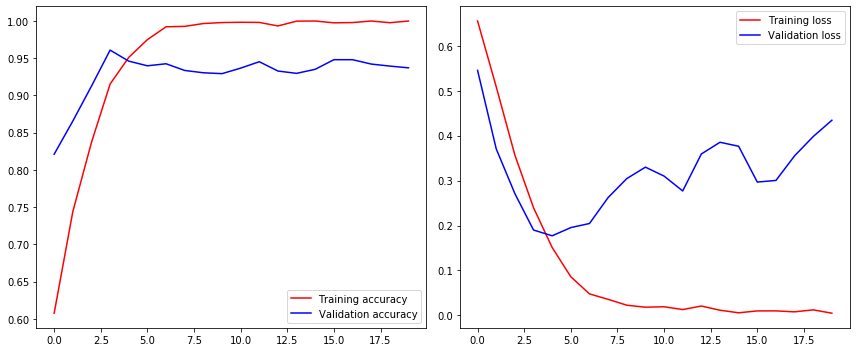

In [69]:
acc = history3.history['acc']
val_acc = history3.history['val_acc']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(len(acc))

fit, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.axes_style('whitegrid')
# plot acrruacy by epochs
sns.lineplot(x=epochs, y=acc, color='r', label='Training accuracy', ax=axes[0])
sns.lineplot(x=epochs, y=val_acc, color = 'b', label='Validation accuracy', ax=axes[0])
# plot loss by epochs
sns.lineplot(x=epochs, y=loss, color='r', label='Training loss', ax=axes[1])
sns.lineplot(x=epochs, y=val_loss, color = 'b', label='Validation loss', ax=axes[1])
plt.tight_layout()
plt.show();

4. 
3 Hidden Layer of 32-64-32 units, dropout ratio 0.25 with l2 regulirization 1e-04, relu for the hidden layer and sigmoid for output layer batch size 256, optimiser adam with lr 1e-03

In [70]:
# Create the model for Relu as hidden layer
model4 = Sequential()

model4.add(Flatten())
 # Layer 1 = hidden layer 
model4.add(layers.Dense(32, activation='relu'))
model4.add(layers.Dropout(0.25))

# Layer 2 = hidden layer 
model4.add(layers.Dense(64, activation='relu', kernel_regularizer= l2(1e-04)))
model4.add(layers.Dropout(0.25))
model4.add(layers.Dense(32, activation='relu'))
# output Layer
model4.add(layers.Dense(10, activation='sigmoid'))
# compile the model
opt4=keras.optimizers.Adam(lr=1e-03)
model4.compile(loss='binary_crossentropy', optimizer=opt4, metrics=['accuracy'])
# train the model
history4 = model4.fit(x=train_features_vgg, y=train_labels_enc,
                    validation_data=(validation_features_vgg, validation_labels_enc),
                    batch_size=256,
                    epochs=20,             
                    verbose=2)

print("==========================Model Evalutation=========================")
testLoss, testAccuracy = model4.evaluate( validation_features_vgg, validation_labels_enc)
print('Loss \t', testLoss)
print('Accuracy ', testAccuracy * 100, '%')
predictions4 = model4.predict(validation_features_vgg)
y_pred = (predictions4 > 0.5)
y_pred = np.argmax(predictions4, axis=1)
print('Confusion Matrix')
confusion_matrix(validation_labels_enc, y_pred)
 

Train on 528 samples, validate on 256 samples
Epoch 1/20
528/528 - 1s - loss: 0.7218 - acc: 0.5174 - val_loss: 0.6720 - val_acc: 0.5633
Epoch 2/20
528/528 - 0s - loss: 0.6713 - acc: 0.5669 - val_loss: 0.6133 - val_acc: 0.6805
Epoch 3/20
528/528 - 0s - loss: 0.6171 - acc: 0.6335 - val_loss: 0.5625 - val_acc: 0.7160
Epoch 4/20
528/528 - 0s - loss: 0.5787 - acc: 0.6553 - val_loss: 0.4969 - val_acc: 0.7828
Epoch 5/20
528/528 - 0s - loss: 0.5263 - acc: 0.7218 - val_loss: 0.4612 - val_acc: 0.8020
Epoch 6/20
528/528 - 0s - loss: 0.4803 - acc: 0.7551 - val_loss: 0.4354 - val_acc: 0.8223
Epoch 7/20
528/528 - 0s - loss: 0.4349 - acc: 0.7737 - val_loss: 0.3858 - val_acc: 0.8727
Epoch 8/20
528/528 - 0s - loss: 0.3746 - acc: 0.8220 - val_loss: 0.3185 - val_acc: 0.9164
Epoch 9/20
528/528 - 0s - loss: 0.3360 - acc: 0.8487 - val_loss: 0.2929 - val_acc: 0.9199
Epoch 10/20
528/528 - 0s - loss: 0.2888 - acc: 0.8765 - val_loss: 0.3157 - val_acc: 0.9043
Epoch 11/20
528/528 - 0s - loss: 0.2363 - acc: 0.9062

array([[  0,  73,   8,   1,  34,  12],
       [  0,   0,   0,   0,   0, 128],
       [  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0]])

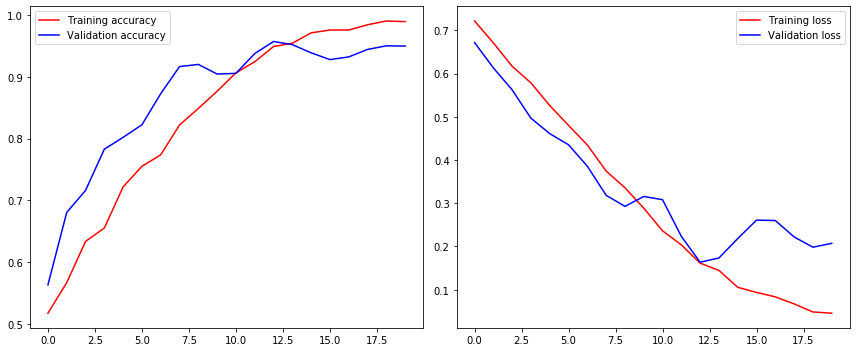

In [71]:
acc = history4.history['acc']
val_acc = history4.history['val_acc']
loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs = range(len(acc))

fit, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.axes_style('whitegrid')
# plot acrruacy by epochs
sns.lineplot(x=epochs, y=acc, color='r', label='Training accuracy', ax=axes[0])
sns.lineplot(x=epochs, y=val_acc, color = 'b', label='Validation accuracy', ax=axes[0])
# plot loss by epochs
sns.lineplot(x=epochs, y=loss, color='r', label='Training loss', ax=axes[1])
sns.lineplot(x=epochs, y=val_loss, color = 'b', label='Validation loss', ax=axes[1])
plt.tight_layout()
plt.show();

5.
3 Hidden Layer of 32-64-32 units, dropout ratio 0.25 with l2 regulirization 1e-04, sigmoid for the hidden layer and sigmoid for output layer batch size 64, optimiser adam 

In [72]:
# Create the model for sigmoid as hidden layer
model5 = Sequential()

model5.add(Flatten())
 
model5.add(layers.Dense(32, activation='sigmoid'))
model5.add(layers.Dropout(0.25))

#  hidden layer 
model5.add(layers.Dense(64, activation='sigmoid', kernel_regularizer= l2(1e-04)))
model5.add(layers.Dropout(0.25))
model5.add(layers.Dense(32, activation='sigmoid'))

model5.add(layers.Dense(10, activation='sigmoid'))
# Compile the model 
opt5=keras.optimizers.Adam(lr=1e-03)
model5.compile(loss='binary_crossentropy', optimizer=opt5, metrics=['accuracy'])
# train the model
history5 = model5.fit(x=train_features_vgg, y=train_labels_enc,
                    validation_data=(validation_features_vgg, validation_labels_enc),
                    batch_size=64,
                    epochs=20,             
                    verbose=2)

print("==========================Model Evalutation=========================")
testLoss, testAccuracy = model5.evaluate( validation_features_vgg, validation_labels_enc)
print('Loss \t', testLoss)
print('Accuracy ', testAccuracy * 100, '%')
predictions5 = model5.predict(validation_features_vgg)
y_pred = (predictions5 > 0.5)
y_pred = np.argmax(predictions5, axis=1)
print('Confusion Matrix')
confusion_matrix(validation_labels_enc, y_pred)

Train on 528 samples, validate on 256 samples
Epoch 1/20
528/528 - 1s - loss: 0.7279 - acc: 0.4989 - val_loss: 0.7080 - val_acc: 0.4883
Epoch 2/20
528/528 - 0s - loss: 0.6990 - acc: 0.5180 - val_loss: 0.6850 - val_acc: 0.5762
Epoch 3/20
528/528 - 0s - loss: 0.6771 - acc: 0.6004 - val_loss: 0.6674 - val_acc: 0.6363
Epoch 4/20
528/528 - 0s - loss: 0.6609 - acc: 0.6956 - val_loss: 0.6497 - val_acc: 0.8414
Epoch 5/20
528/528 - 0s - loss: 0.6363 - acc: 0.8061 - val_loss: 0.6264 - val_acc: 0.8547
Epoch 6/20
528/528 - 0s - loss: 0.6096 - acc: 0.8813 - val_loss: 0.5951 - val_acc: 0.9008
Epoch 7/20
528/528 - 0s - loss: 0.5736 - acc: 0.9297 - val_loss: 0.5560 - val_acc: 0.9031
Epoch 8/20
528/528 - 0s - loss: 0.5291 - acc: 0.9634 - val_loss: 0.5083 - val_acc: 0.9484
Epoch 9/20
528/528 - 0s - loss: 0.4721 - acc: 0.9920 - val_loss: 0.4590 - val_acc: 0.9473
Epoch 10/20
528/528 - 0s - loss: 0.4158 - acc: 0.9998 - val_loss: 0.4077 - val_acc: 0.9465
Epoch 11/20
528/528 - 0s - loss: 0.3572 - acc: 0.9998

array([[  0,  14,   1, 113],
       [  0, 128,   0,   0],
       [  0,   0,   0,   0],
       [  0,   0,   0,   0]])

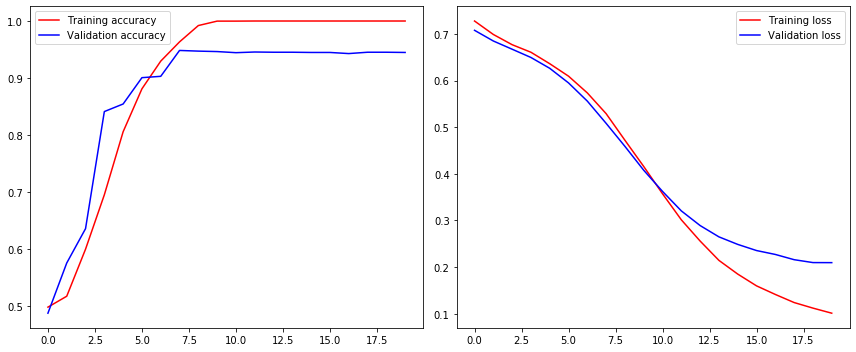

In [73]:
acc = history5.history['acc']
val_acc = history5.history['val_acc']
loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs = range(len(acc))

fit, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.axes_style('whitegrid')
# plot acrruacy by epochs
sns.lineplot(x=epochs, y=acc, color='r', label='Training accuracy', ax=axes[0])
sns.lineplot(x=epochs, y=val_acc, color = 'b', label='Validation accuracy', ax=axes[0])
# plot loss by epochs
sns.lineplot(x=epochs, y=loss, color='r', label='Training loss', ax=axes[1])
sns.lineplot(x=epochs, y=val_loss, color = 'b', label='Validation loss', ax=axes[1])
plt.tight_layout()
plt.show();

6.
3 Hidden Layer of 32-64-32 units, dropout ratio 0.25 with l2 regulirization 1e-04, sigmoid for the hidden layer and sigmoid for output layer batch size 256, optimiser adam  with lr 1e-03

In [74]:
# Create the model for sigmoid as hidden layer
model6 = Sequential()

model6.add(Flatten())
 
model6.add(layers.Dense(32, activation='sigmoid'))
model6.add(layers.Dropout(0.25))

model6.add(layers.Dense(64, activation='sigmoid', kernel_regularizer= l2(1e-04)))
model6.add(layers.Dropout(0.25))
model6.add(layers.Dense(32, activation='sigmoid'))

model6.add(layers.Dense(10, activation='sigmoid'))
opt6=keras.optimizers.Adam(lr=1e-03)
model6.compile(loss='binary_crossentropy', optimizer=opt6, metrics=['accuracy'])

history6 = model6.fit(x=train_features_vgg, y=train_labels_enc,
                    validation_data=(validation_features_vgg, validation_labels_enc),
                    batch_size=256,
                    epochs=20,             
                    verbose=2)


print("==========================Model Evalutation=========================")
testLoss, testAccuracy = model6.evaluate( validation_features_vgg, validation_labels_enc)
print('Loss \t', testLoss)
print('Accuracy ', testAccuracy * 100, '%')
predictions6 = model6.predict(validation_features_vgg)
y_pred = (predictions6 > 0.5)
y_pred = np.argmax(predictions6, axis=1)
print('Confusion Matrix')
confusion_matrix(validation_labels_enc, y_pred)

Train on 528 samples, validate on 256 samples
Epoch 1/20
528/528 - 1s - loss: 0.7307 - acc: 0.5008 - val_loss: 0.7158 - val_acc: 0.5000
Epoch 2/20
528/528 - 0s - loss: 0.7171 - acc: 0.5093 - val_loss: 0.7056 - val_acc: 0.5461
Epoch 3/20
528/528 - 0s - loss: 0.7068 - acc: 0.5295 - val_loss: 0.6982 - val_acc: 0.5000
Epoch 4/20
528/528 - 0s - loss: 0.7007 - acc: 0.5328 - val_loss: 0.6930 - val_acc: 0.5398
Epoch 5/20
528/528 - 0s - loss: 0.6942 - acc: 0.5384 - val_loss: 0.6887 - val_acc: 0.5484
Epoch 6/20
528/528 - 0s - loss: 0.6887 - acc: 0.5653 - val_loss: 0.6842 - val_acc: 0.5000
Epoch 7/20
528/528 - 0s - loss: 0.6857 - acc: 0.5667 - val_loss: 0.6797 - val_acc: 0.5363
Epoch 8/20
528/528 - 0s - loss: 0.6813 - acc: 0.5826 - val_loss: 0.6756 - val_acc: 0.5906
Epoch 9/20
528/528 - 0s - loss: 0.6766 - acc: 0.6032 - val_loss: 0.6713 - val_acc: 0.6406
Epoch 10/20
528/528 - 0s - loss: 0.6723 - acc: 0.6439 - val_loss: 0.6668 - val_acc: 0.7359
Epoch 11/20
528/528 - 0s - loss: 0.6671 - acc: 0.6867

array([[  2,   0,   1,  10, 115],
       [  0,   0,   0, 128,   0],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0]])

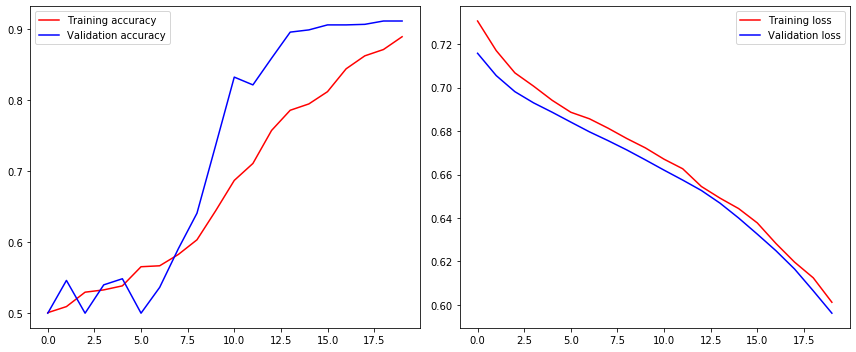

In [75]:
acc = history6.history['acc']
val_acc = history6.history['val_acc']
loss = history6.history['loss']
val_loss = history6.history['val_loss']

epochs = range(len(acc))

fit, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.axes_style('whitegrid')
# plot acrruacy by epochs
sns.lineplot(x=epochs, y=acc, color='r', label='Training accuracy', ax=axes[0])
sns.lineplot(x=epochs, y=val_acc, color = 'b', label='Validation accuracy', ax=axes[0])
# plot loss by epochs
sns.lineplot(x=epochs, y=loss, color='r', label='Training loss', ax=axes[1])
sns.lineplot(x=epochs, y=val_loss, color = 'b', label='Validation loss', ax=axes[1])
plt.tight_layout()
plt.show();

7. 
1 Hidden Layer of 32 units, dropout ratio 0.25, relu for the hidden layer and sigmoid for output layer batch size 64, optimiser SGD with lr 1e-02 and momentum 0.95


In [76]:

# Create the model for Relu as hidden layer
model7 = Sequential()
# Specify the input size for first layer
model7.add(Flatten())
model7.add(layers.Dense(32, activation='relu', input_shape= ( 32*32,)))
model7.add(layers.Dropout(0.25))

# Layer 5 = output layer
model7.add(layers.Dense(10, activation='sigmoid'))
learning_rate = 1e-02
momentum = 0.95
sgd =keras.optimizers.SGD(lr=learning_rate, momentum=momentum)
model7.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
#model.summary()
history7 = model7.fit(x=train_features_vgg, y=train_labels_enc,
                    validation_data=(validation_features_vgg, validation_labels_enc),
                    batch_size=64,
                    epochs=20,             
                    verbose=2)
print("==========================Model Evalutation=========================")
testLoss, testAccuracy = model7.evaluate( validation_features_vgg, validation_labels_enc)
print('Loss \t', testLoss)
print('Accuracy ', testAccuracy * 100, '%')

predictions7 = model7.predict(validation_features_vgg)
y_pred = (predictions7 > 0.5)
y_pred = np.argmax(predictions7, axis=1)
print('Confusion Matrix')
confusion_matrix(validation_labels_enc, y_pred)

Train on 528 samples, validate on 256 samples
Epoch 1/20
528/528 - 1s - loss: 0.6960 - acc: 0.5523 - val_loss: 0.6360 - val_acc: 0.6445
Epoch 2/20
528/528 - 0s - loss: 0.5871 - acc: 0.6830 - val_loss: 0.4808 - val_acc: 0.7828
Epoch 3/20
528/528 - 0s - loss: 0.4478 - acc: 0.7737 - val_loss: 0.3209 - val_acc: 0.8891
Epoch 4/20
528/528 - 0s - loss: 0.2759 - acc: 0.8873 - val_loss: 0.1447 - val_acc: 0.9660
Epoch 5/20
528/528 - 0s - loss: 0.1407 - acc: 0.9523 - val_loss: 0.1063 - val_acc: 0.9629
Epoch 6/20
528/528 - 0s - loss: 0.0779 - acc: 0.9786 - val_loss: 0.1331 - val_acc: 0.9547
Epoch 7/20
528/528 - 0s - loss: 0.0468 - acc: 0.9850 - val_loss: 0.1139 - val_acc: 0.9625
Epoch 8/20
528/528 - 0s - loss: 0.0365 - acc: 0.9894 - val_loss: 0.1839 - val_acc: 0.9488
Epoch 9/20
528/528 - 0s - loss: 0.0286 - acc: 0.9917 - val_loss: 0.1150 - val_acc: 0.9660
Epoch 10/20
528/528 - 0s - loss: 0.0242 - acc: 0.9922 - val_loss: 0.1476 - val_acc: 0.9617
Epoch 11/20
528/528 - 0s - loss: 0.0176 - acc: 0.9956

array([[  0,   0,  35,  11,  82],
       [  0,   0,   0, 128,   0],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0]])

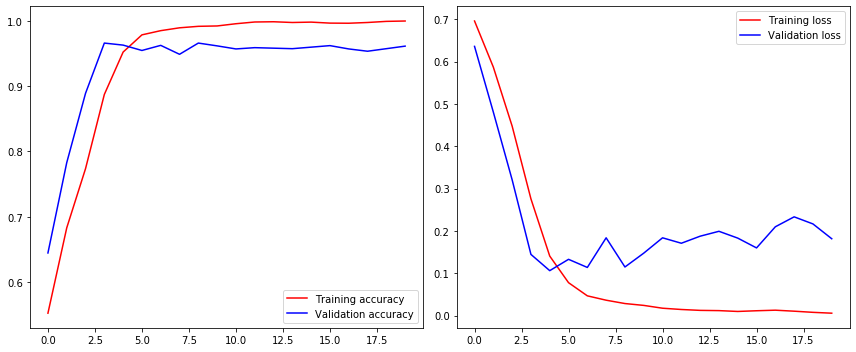

In [77]:
acc = history7.history['acc']
val_acc = history7.history['val_acc']
loss = history7.history['loss']
val_loss = history7.history['val_loss']

epochs = range(len(acc))

fit, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.axes_style('whitegrid')
# plot acrruacy by epochs
sns.lineplot(x=epochs, y=acc, color='r', label='Training accuracy', ax=axes[0])
sns.lineplot(x=epochs, y=val_acc, color = 'b', label='Validation accuracy', ax=axes[0])
# plot loss by epochs
sns.lineplot(x=epochs, y=loss, color='r', label='Training loss', ax=axes[1])
sns.lineplot(x=epochs, y=val_loss, color = 'b', label='Validation loss', ax=axes[1])
plt.tight_layout()
plt.show();

8. 
1 Hidden Layer of 32 units, dropout ratio 0.25, relu for the hidden layer and sigmoid for output layer batch size 256, optimiser SGD with lr 1e-02 and momentum 0.95



In [78]:
# Create the model for Relu as hidden layer
model8 = Sequential()
# Specify the input size for first layer
model8.add(Flatten())
model8.add(layers.Dense(32, activation='relu', input_shape= ( 32*32,)))
model8.add(layers.Dropout(0.25))

# Layer 5 = output layer
model8.add(layers.Dense(10, activation='sigmoid'))
learning_rate = 1e-02
momentum = 0.95
sgd =keras.optimizers.SGD(lr=learning_rate, momentum=momentum)
model8.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
#model.summary()
history8 = model8.fit(x=train_features_vgg, y=train_labels_enc,
                    validation_data=(validation_features_vgg, validation_labels_enc),
                    batch_size=256,
                    epochs=20,             
                    verbose=2)
print("==========================Model Evalutation=========================")
testLoss, testAccuracy = model8.evaluate( validation_features_vgg, validation_labels_enc)
print('Loss \t', testLoss)
print('Accuracy ', testAccuracy * 100, '%')

predictions8 = model8.predict(validation_features_vgg)
y_pred = (predictions2 > 0.5)
y_pred = np.argmax(predictions8, axis=1)
print('Confusion Matrix')
confusion_matrix(validation_labels_enc, y_pred)

Train on 528 samples, validate on 256 samples
Epoch 1/20
528/528 - 1s - loss: 0.7221 - acc: 0.5006 - val_loss: 0.6842 - val_acc: 0.5555
Epoch 2/20
528/528 - 0s - loss: 0.6852 - acc: 0.5402 - val_loss: 0.6681 - val_acc: 0.6102
Epoch 3/20
528/528 - 0s - loss: 0.6519 - acc: 0.6364 - val_loss: 0.6427 - val_acc: 0.5754
Epoch 4/20
528/528 - 0s - loss: 0.6325 - acc: 0.6225 - val_loss: 0.5706 - val_acc: 0.7043
Epoch 5/20
528/528 - 0s - loss: 0.6088 - acc: 0.6110 - val_loss: 0.5328 - val_acc: 0.7703
Epoch 6/20
528/528 - 0s - loss: 0.5304 - acc: 0.7170 - val_loss: 0.5053 - val_acc: 0.7699
Epoch 7/20
528/528 - 0s - loss: 0.4927 - acc: 0.7366 - val_loss: 0.4061 - val_acc: 0.8367
Epoch 8/20
528/528 - 0s - loss: 0.4254 - acc: 0.7970 - val_loss: 0.3531 - val_acc: 0.8539
Epoch 9/20
528/528 - 0s - loss: 0.3862 - acc: 0.8034 - val_loss: 0.2600 - val_acc: 0.9449
Epoch 10/20
528/528 - 0s - loss: 0.3174 - acc: 0.8631 - val_loss: 0.1952 - val_acc: 0.9703
Epoch 11/20
528/528 - 0s - loss: 0.2695 - acc: 0.8911

array([[  0,   0, 111,  17],
       [  0,   0,   0, 128],
       [  0,   0,   0,   0],
       [  0,   0,   0,   0]])

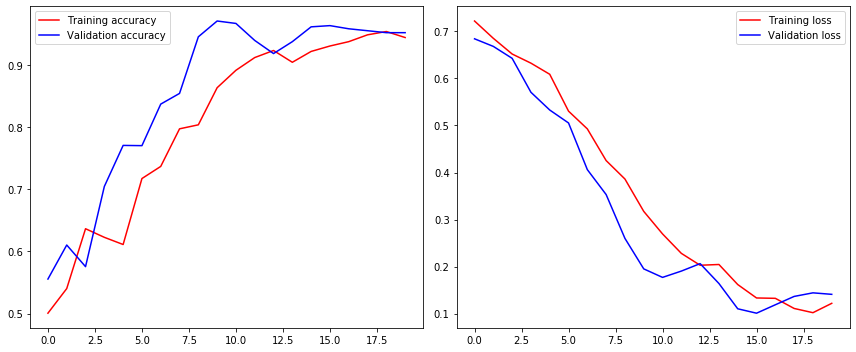

In [79]:
acc = history8.history['acc']
val_acc = history8.history['val_acc']
loss = history8.history['loss']
val_loss = history8.history['val_loss']

epochs = range(len(acc))

fit, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.axes_style('whitegrid')
# plot acrruacy by epochs
sns.lineplot(x=epochs, y=acc, color='r', label='Training accuracy', ax=axes[0])
sns.lineplot(x=epochs, y=val_acc, color = 'b', label='Validation accuracy', ax=axes[0])
# plot loss by epochs
sns.lineplot(x=epochs, y=loss, color='r', label='Training loss', ax=axes[1])
sns.lineplot(x=epochs, y=val_loss, color = 'b', label='Validation loss', ax=axes[1])
plt.tight_layout()
plt.show();

9. 
3 Hidden Layer of 32-64-32 units, dropout ratio 0.25 with l2 regulirization 1e-04, relu for the hidden layer and sigmoid for output layer batch size 64, optimiser SGD with lr 1e-02 and momentum 0.95


In [80]:
# Create the model for Relu as hidden layer
model9 = Sequential()

model9.add(Flatten())
 
model9.add(layers.Dense(32, activation='relu'))
model9.add(layers.Dropout(0.25))

model9.add(layers.Dense(64, activation='relu', kernel_regularizer= l2(1e-04)))
model9.add(layers.Dropout(0.25))
model9.add(layers.Dense(32, activation='relu'))

model9.add(layers.Dense(10, activation='sigmoid'))
learning_rate = 1e-02
momentum = 0.95
sgd =keras.optimizers.SGD(lr=learning_rate, momentum=momentum)
model9.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

history9 = model9.fit(x=train_features_vgg, y=train_labels_enc,
                    validation_data=(validation_features_vgg, validation_labels_enc),
                    batch_size=64,
                    epochs=20,             
                    verbose=2)

print("==========================Model Evalutation=========================")
testLoss, testAccuracy = model9.evaluate( validation_features_vgg, validation_labels_enc)
print('Loss \t', testLoss)
print('Accuracy ', testAccuracy * 100, '%')
predictions9 = model9.predict(validation_features_vgg)
y_pred = (predictions9 > 0.5)
y_pred = np.argmax(predictions9, axis=1)
print('Confusion Matrix')
confusion_matrix(validation_labels_enc, y_pred)

Train on 528 samples, validate on 256 samples
Epoch 1/20
528/528 - 1s - loss: 0.7054 - acc: 0.5070 - val_loss: 0.6899 - val_acc: 0.5648
Epoch 2/20
528/528 - 0s - loss: 0.6911 - acc: 0.5322 - val_loss: 0.6749 - val_acc: 0.6086
Epoch 3/20
528/528 - 0s - loss: 0.6628 - acc: 0.5960 - val_loss: 0.6126 - val_acc: 0.7195
Epoch 4/20
528/528 - 0s - loss: 0.5960 - acc: 0.6968 - val_loss: 0.4673 - val_acc: 0.8492
Epoch 5/20
528/528 - 0s - loss: 0.4385 - acc: 0.8244 - val_loss: 0.3457 - val_acc: 0.8816
Epoch 6/20
528/528 - 0s - loss: 0.2430 - acc: 0.9170 - val_loss: 0.4382 - val_acc: 0.8738
Epoch 7/20
528/528 - 0s - loss: 0.1761 - acc: 0.9337 - val_loss: 0.5840 - val_acc: 0.8672
Epoch 8/20
528/528 - 0s - loss: 0.1937 - acc: 0.9210 - val_loss: 0.1699 - val_acc: 0.9598
Epoch 9/20
528/528 - 0s - loss: 0.0795 - acc: 0.9784 - val_loss: 0.2089 - val_acc: 0.9605
Epoch 10/20
528/528 - 0s - loss: 0.0912 - acc: 0.9678 - val_loss: 0.4951 - val_acc: 0.9234
Epoch 11/20
528/528 - 0s - loss: 0.0569 - acc: 0.9818

array([[  0,   0,   4,   5, 111,   8],
       [  0,   0,   0,   0,   0, 128],
       [  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0]])

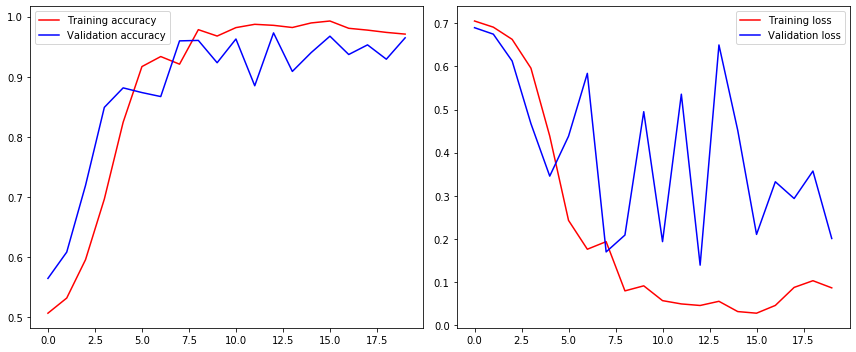

In [81]:
acc = history9.history['acc']
val_acc = history9.history['val_acc']
loss = history9.history['loss']
val_loss = history9.history['val_loss']

epochs = range(len(acc))

fit, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.axes_style('whitegrid')
# plot acrruacy by epochs
sns.lineplot(x=epochs, y=acc, color='r', label='Training accuracy', ax=axes[0])
sns.lineplot(x=epochs, y=val_acc, color = 'b', label='Validation accuracy', ax=axes[0])
# plot loss by epochs
sns.lineplot(x=epochs, y=loss, color='r', label='Training loss', ax=axes[1])
sns.lineplot(x=epochs, y=val_loss, color = 'b', label='Validation loss', ax=axes[1])
plt.tight_layout()
plt.show();

10. 
3 Hidden Layer of 32-64-32 units, dropout ratio 0.25 with l2 regulirization 1e-04, relu for the hidden layer and sigmoid for output layer batch size 256, optimiser optimiser SGD with lr 1e-02 and momentum 0.95

In [88]:
# Create the model for Relu as hidden layer
model10 = Sequential()

model10.add(Flatten())
 
model10.add(layers.Dense(32, activation='relu'))
model10.add(layers.Dropout(0.25))

model10.add(layers.Dense(64, activation='relu', kernel_regularizer= l2(1e-04)))
model10.add(layers.Dropout(0.25))
model10.add(layers.Dense(32, activation='relu'))

model10.add(layers.Dense(10, activation='sigmoid'))
learning_rate = 1e-02
momentum = 0.95
sgd =keras.optimizers.SGD(lr=learning_rate, momentum=momentum)
model10.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

history10 = model10.fit(x=train_features_vgg, y=train_labels_enc,
                    validation_data=(validation_features_vgg, validation_labels_enc),
                    batch_size=256,
                    epochs=20,             
                    verbose=2)

print("==========================Model Evalutation=========================")
testLoss, testAccuracy = model10.evaluate( validation_features_vgg, validation_labels_enc)
print('Loss \t', testLoss)
print('Accuracy ', testAccuracy * 100, '%')
predictions10 = model10.predict(validation_features_vgg)
y_pred = (predictions10 > 0.5)
y_pred = np.argmax(predictions10, axis=1)
print('Confusion Matrix')
confusion_matrix(validation_labels_enc, y_pred)

Train on 528 samples, validate on 256 samples
Epoch 1/20
528/528 - 1s - loss: 0.7076 - acc: 0.5044 - val_loss: 0.6810 - val_acc: 0.5609
Epoch 2/20
528/528 - 0s - loss: 0.6910 - acc: 0.5464 - val_loss: 0.6763 - val_acc: 0.5738
Epoch 3/20
528/528 - 0s - loss: 0.6788 - acc: 0.5767 - val_loss: 0.6669 - val_acc: 0.5520
Epoch 4/20
528/528 - 0s - loss: 0.6623 - acc: 0.5881 - val_loss: 0.6192 - val_acc: 0.7086
Epoch 5/20
528/528 - 0s - loss: 0.6282 - acc: 0.6672 - val_loss: 0.5798 - val_acc: 0.7633
Epoch 6/20
528/528 - 0s - loss: 0.6077 - acc: 0.6674 - val_loss: 0.5594 - val_acc: 0.7336
Epoch 7/20
528/528 - 0s - loss: 0.5710 - acc: 0.6920 - val_loss: 0.5169 - val_acc: 0.7617
Epoch 8/20
528/528 - 0s - loss: 0.5223 - acc: 0.7437 - val_loss: 0.4545 - val_acc: 0.8543
Epoch 9/20
528/528 - 0s - loss: 0.4886 - acc: 0.7759 - val_loss: 0.3951 - val_acc: 0.8828
Epoch 10/20
528/528 - 0s - loss: 0.4399 - acc: 0.7939 - val_loss: 0.3881 - val_acc: 0.8633
Epoch 11/20
528/528 - 0s - loss: 0.3711 - acc: 0.8369

array([[  0,   0,  40,   6,  82],
       [  0,   0, 128,   0,   0],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0]])

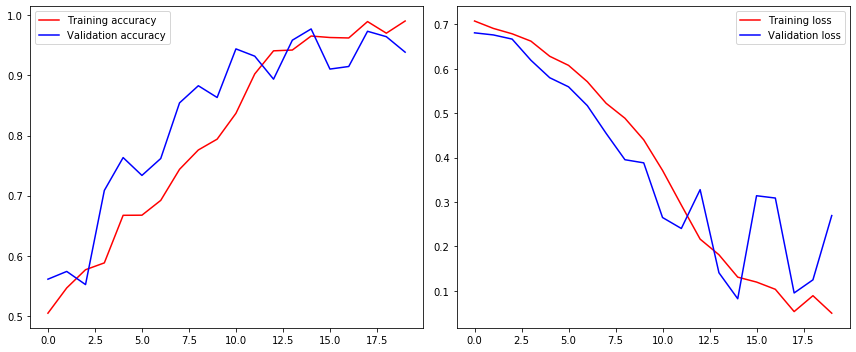

In [89]:
acc = history10.history['acc']
val_acc = history10.history['val_acc']
loss = history10.history['loss']
val_loss = history10.history['val_loss']

epochs = range(len(acc))

fit, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.axes_style('whitegrid')
# plot acrruacy by epochs
sns.lineplot(x=epochs, y=acc, color='r', label='Training accuracy', ax=axes[0])
sns.lineplot(x=epochs, y=val_acc, color = 'b', label='Validation accuracy', ax=axes[0])
# plot loss by epochs
sns.lineplot(x=epochs, y=loss, color='r', label='Training loss', ax=axes[1])
sns.lineplot(x=epochs, y=val_loss, color = 'b', label='Validation loss', ax=axes[1])
plt.tight_layout()
plt.show();

11.
3 Hidden Layer of 32-64-32 units, dropout ratio 0.25 with l2 regulirization 1e-04, sigmoid for the hidden layer and sigmoid for output layer batch size 64, optimiser SGD with lr 1e-02 and momentum 0.95

In [99]:
# Create the model for Sigmoid as hidden layer
model11 = Sequential()

model11.add(Flatten())
 
model11.add(layers.Dense(32, activation='sigmoid'))
model11.add(layers.Dropout(0.25))

# Layer 3 = hidden layer 
model11.add(layers.Dense(64, activation='sigmoid', kernel_regularizer= l2(1e-04)))
model11.add(layers.Dropout(0.25))
model11.add(layers.Dense(32, activation='sigmoid'))

model11.add(layers.Dense(10, activation='sigmoid'))
learning_rate = 1e-02
momentum = 0.95
sgd =keras.optimizers.SGD(lr=learning_rate, momentum=momentum)
model11.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

history11 = model11.fit(x=train_features_vgg, y=train_labels_enc,
                    validation_data=(validation_features_vgg, validation_labels_enc),
                    batch_size=64,
                    epochs=20,             
                    verbose=2)


print("==========================Model Evalutation=========================")
testLoss, testAccuracy = model11.evaluate( validation_features_vgg, validation_labels_enc)
print('Loss \t', testLoss)
print('Accuracy ', testAccuracy * 100, '%')
predictions11 = model11.predict(validation_features_vgg)
y_pred = (predictions11 > 0.5)
y_pred = np.argmax(predictions11, axis=1)
print('Confusion Matrix')
confusion_matrix(validation_labels_enc, y_pred)

Train on 528 samples, validate on 256 samples
Epoch 1/20
528/528 - 1s - loss: 0.7469 - acc: 0.5032 - val_loss: 0.7356 - val_acc: 0.5000
Epoch 2/20
528/528 - 0s - loss: 0.7311 - acc: 0.4970 - val_loss: 0.7171 - val_acc: 0.5000
Epoch 3/20
528/528 - 0s - loss: 0.7121 - acc: 0.4958 - val_loss: 0.7035 - val_acc: 0.5062
Epoch 4/20
528/528 - 0s - loss: 0.7009 - acc: 0.5006 - val_loss: 0.6977 - val_acc: 0.5000
Epoch 5/20
528/528 - 0s - loss: 0.6978 - acc: 0.5019 - val_loss: 0.6968 - val_acc: 0.5266
Epoch 6/20
528/528 - 0s - loss: 0.6973 - acc: 0.5134 - val_loss: 0.6974 - val_acc: 0.5000
Epoch 7/20
528/528 - 0s - loss: 0.6982 - acc: 0.5106 - val_loss: 0.6976 - val_acc: 0.5000
Epoch 8/20
528/528 - 0s - loss: 0.6977 - acc: 0.5136 - val_loss: 0.6968 - val_acc: 0.5000
Epoch 9/20
528/528 - 0s - loss: 0.6957 - acc: 0.5146 - val_loss: 0.6956 - val_acc: 0.5000
Epoch 10/20
528/528 - 0s - loss: 0.6953 - acc: 0.5259 - val_loss: 0.6944 - val_acc: 0.5004
Epoch 11/20
528/528 - 0s - loss: 0.6933 - acc: 0.5394

array([[  0,   3,  81,  26,   0,  18,   0],
       [  0, 126,   0,   0,   1,   0,   1],
       [  0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0]])

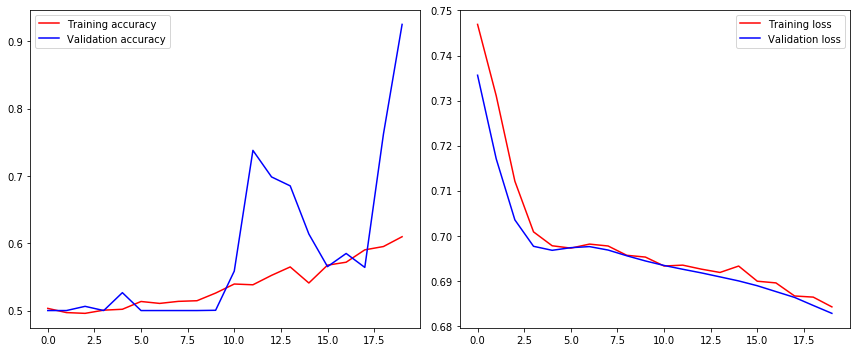

In [102]:
acc = history11.history['acc']
val_acc = history11.history['val_acc']
loss = history11.history['loss']
val_loss = history11.history['val_loss']

epochs = range(len(acc))

fit, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.axes_style('whitegrid')
# plot acrruacy by epochs
sns.lineplot(x=epochs, y=acc, color='r', label='Training accuracy', ax=axes[0])
sns.lineplot(x=epochs, y=val_acc, color = 'b', label='Validation accuracy', ax=axes[0])
# plot loss by epochs
sns.lineplot(x=epochs, y=loss, color='r', label='Training loss', ax=axes[1])
sns.lineplot(x=epochs, y=val_loss, color = 'b', label='Validation loss', ax=axes[1])
plt.tight_layout()
plt.show();

Summarisation                                         
  Highest Accuracy:    96.48 %          
Relu as hidden layer, sigmoid as output with dropout and regularisation with optimizer SGD(lr 1e-02 and momentum 0.95)having batch size 64 has given maximum accuracy for the given data set.        

  Lowest Accuracy:     91.09 %         
Sigmoid as hidden layer, sigmoid as output with dropout and regularisation with optimizer Adam(lr 1e-03 )having batch size 256 has given minimum accuracy for the given data set. This could be the case of overfitting.      